In [1]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports
import GEMS_TCO
from GEMS_TCO import kernels

from GEMS_TCO import kernels 
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import load_data
from GEMS_TCO import alg_optimization, alg_opt_Encoder
from GEMS_TCO import configuration as config

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder

from GEMS_TCO import configuration as config
from GEMS_TCO import data_preprocess as dmbh

import os
from sklearn.neighbors import BallTree

In [2]:
import pickle
import os
# Assume your 'config' object is available
# import config

# --- 1. Configuration ---
# Specify the year and month you want to load
YEAR_TO_LOAD = 2024
MONTH_TO_LOAD = 7

# Use the same base path as your saving script
BASE_PATH = config.mac_data_load_path

# --- 2. Construct the File Path ---
# This must exactly match the naming convention from your saving script
month_str = f"{MONTH_TO_LOAD:02d}"
pickle_path = os.path.join(BASE_PATH, f'pickle_{YEAR_TO_LOAD}')
filename = f"coarse_cen_map_without_decrement_latitude{str(YEAR_TO_LOAD)[2:]}_{month_str}.pkl"
filepath_to_load = os.path.join(pickle_path, filename)

print(f"Attempting to load data from: {filepath_to_load}")

# --- 3. Load the Data ---
try:
    with open(filepath_to_load, 'rb') as pickle_file:
        # Use pickle.load() to read the data from the file
        loaded_coarse_map = pickle.load(pickle_file)
    
    print("\nData loaded successfully! ✅")
    
    # --- 4. Verify the Loaded Data ---
    # The loaded data is a dictionary. Let's inspect it.
    print(f"Type of loaded data: {type(loaded_coarse_map)}")
    if isinstance(loaded_coarse_map, dict):
        print(f"Number of entries (hours) in the map: {len(loaded_coarse_map)}")
        # Print the first 5 keys to see what they look like
        first_five_keys = list(loaded_coarse_map.keys())[:5]
        print(f"Example keys: {first_five_keys}")
        
        # You can now access the data for a specific hour, for example:
        # first_hour_data = loaded_coarse_map[first_five_keys[0]]
        # print(f"\nData for first hour is a tensor of shape: {first_hour_data.shape}")

except FileNotFoundError:
    print(f"\nError: File not found. Please check if the file exists at the specified path.")
except Exception as e:
    print(f"\nAn error occurred: {e}")


print(loaded_coarse_map['y24m07day01_hm00:53']['Longitude'].nunique())
print(loaded_coarse_map['y24m07day01_hm00:53']['Latitude'].nunique())

import GEMS_TCO
load_data_instance = GEMS_TCO.load_data('')

df_day_aggregated_list = []
df_day_map_list = []
for i in range(31):
    cur_map, cur_df =load_data_instance.load_working_data_byday_wo_mm(loaded_coarse_map,[i*8, (i+1)*8])
    df_day_aggregated_list.append( cur_df )
    df_day_map_list.append( cur_map )

Attempting to load data from: /Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/coarse_cen_map_without_decrement_latitude24_07.pkl

Data loaded successfully! ✅
Type of loaded data: <class 'dict'>
Number of entries (hours) in the map: 248
Example keys: ['y24m07day01_hm00:53', 'y24m07day01_hm01:53', 'y24m07day01_hm02:53', 'y24m07day01_hm03:53', 'y24m07day01_hm04:49']
270
273


## 3d first differencing

In [3]:
import torch
import numpy as np
import torch.nn.functional as F

# --- Helper Function (Unchanged) ---
def subset_tensor(df_tensor: torch.Tensor) -> torch.Tensor:
    """
    Subsets a tensor to a specific lat/lon range.
    Columns are assumed to be [lat, lon, ozone, time].
    """
    lat_mask = (df_tensor[:, 0] >= -5) & (df_tensor[:, 0] <= 6.3)
    lon_mask = (df_tensor[:, 1] >= 118) & (df_tensor[:, 1] <= 134.2)
    #lat_mask = (df_tensor[:, 0] >= 0) & (df_tensor[:, 0] <= 5)
    #lon_mask = (df_tensor[:, 1] >= 123) & (df_tensor[:, 1] <= 133)
    return df_tensor[lat_mask & lon_mask].clone()

# --- NEW 3D Differencing Function ---
def apply_first_difference_3d(day_tensor: torch.Tensor) -> torch.Tensor:
    """
    Applies a 3D first-difference filter to calculate the gradient (rate of change)
    simultaneously across time, latitude, and longitude.

    Args:
        day_tensor: A tensor for a single day with columns [lat, lon, ozone, time].

    Returns:
        A tensor with columns [lat, lon, time, grad_t, grad_lat, grad_lon].
    """
    if day_tensor.numel() == 0:
        return torch.empty(0, 6)

    # 1. Map long-format data to a dense 3D grid
    unique_lats = torch.unique(day_tensor[:, 0])
    unique_lons = torch.unique(day_tensor[:, 1])
    unique_times = torch.unique(day_tensor[:, 3])
    
    T, H, W = len(unique_times), len(unique_lats), len(unique_lons)
    if T < 2 or H < 2 or W < 2:
        return torch.empty(0, 6) # Not enough data to compute a 3D difference

    lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
    lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}
    time_map = {time.item(): i for i, time in enumerate(unique_times)}

    ozone_grid = torch.zeros(T, H, W, dtype=torch.float32)
    for row in day_tensor:
        lat, lon, ozone, time = row
        t_idx, h_idx, w_idx = time_map[time.item()], lat_map[lat.item()], lon_map[lon.item()]
        ozone_grid[t_idx, h_idx, w_idx] = ozone
    
    # Reshape for conv3d: (N, C_in, D, H, W) -> (1, 1, Time, Lat, Lon)
    ozone_grid = ozone_grid.unsqueeze(0).unsqueeze(0)

    # 2. Define 3D kernels for first difference Z(i) - Z(i-1) along each axis
    kernel_t = torch.tensor([-1., 1.], dtype=torch.float32).reshape(1, 1, 2, 1, 1)
    kernel_lat = torch.tensor([-1., 1.], dtype=torch.float32).reshape(1, 1, 1, 2, 1)
    kernel_lon = torch.tensor([-1., 1.], dtype=torch.float32).reshape(1, 1, 1, 1, 2)

    # 3. Apply 3D convolution to get gradient components
    grad_t = F.conv3d(ozone_grid, kernel_t, padding='valid')
    grad_lat = F.conv3d(ozone_grid, kernel_lat, padding='valid')
    grad_lon = F.conv3d(ozone_grid, kernel_lon, padding='valid')

    # 4. Align gradient grids to a common shape and reconstruct output tensor
    # The common grid where all gradients are defined is (T-1, H-1, W-1)
    grad_t_common = grad_t.squeeze()[:, 1:, 1:]
    grad_lat_common = grad_lat.squeeze()[1:, :, 1:]
    grad_lon_common = grad_lon.squeeze()[1:, 1:, :]

    # Create new coordinate grids corresponding to the common gradient grid
    new_times, new_lats, new_lons = unique_times[1:], unique_lats[1:], unique_lons[1:]
    time_grid, lat_grid, lon_grid = torch.meshgrid(new_times, new_lats, new_lons, indexing='ij')

    # Flatten and stack coordinates with their corresponding gradient values
    final_tensor = torch.stack([
        lat_grid.flatten(),
        lon_grid.flatten(),
        time_grid.flatten(),
        grad_t_common.flatten(),
        grad_lat_common.flatten(),
        grad_lon_common.flatten()
    ], dim=1)
    
    return final_tensor

# --- Main Processing Loop ---

# Assuming df_day_map_list is pre-loaded and sorted by date
all_gradient_tensors = []
for day_map in df_day_map_list:
    # Aggregate all data for one day and apply the initial spatial subset
    tensors_for_day = [subset_tensor(t) for t in day_map.values() if t.numel() > 0]

    if not tensors_for_day:
        continue
        
    full_day_tensor = torch.cat(tensors_for_day, dim=0)
    
    # Apply the unified 3D differencing function to the day's data
    gradient_tensor = apply_first_difference_3d(full_day_tensor)
    
    if gradient_tensor.size(0) > 0:
        all_gradient_tensors.append(gradient_tensor)

# --- Verification ---
print(f"Number of final gradient tensors (one per day): {len(all_gradient_tensors)}")

if all_gradient_tensors:
    print("\nShape of the first day's gradient tensor:", all_gradient_tensors[0].shape)
    print("Columns: [lat, lon, time, grad_t, grad_lat, grad_lon]")
    print("Head of the first gradient tensor:")
    print(all_gradient_tensors[0][:5])

Number of final gradient tensors (one per day): 31

Shape of the first day's gradient tensor: torch.Size([458752, 6])
Columns: [lat, lon, time, grad_t, grad_lat, grad_lon]
Head of the first gradient tensor:
tensor([[-4.9240e+00,  1.1812e+02,  2.2000e+01, -1.1864e+00,  6.2909e-01,
          1.5581e+00],
        [-4.9240e+00,  1.1818e+02,  2.2000e+01, -7.8925e-01,  2.2599e+00,
          3.1329e-01],
        [-4.9240e+00,  1.1824e+02,  2.2000e+01,  4.3935e+00,  7.3975e-02,
         -4.1911e+00],
        [-4.9240e+00,  1.1831e+02,  2.2000e+01,  5.7640e+00, -2.7642e+00,
          2.7431e+00],
        [-4.9240e+00,  1.1837e+02,  2.2000e+01, -1.1370e+01, -3.4481e+00,
         -8.2580e+00]])


--- Day 1 Diagnostic Plot for 3D GRADIENT Data ---
Using pre-defined natural-scale parameters: [7.7046, 1.952, 4.1366, -1.0769, -0.3244, 0.1074, 3.9057]
Using log-space params for model: [ 2.0418  0.6689  1.4199 -1.0769 -0.3244  0.1074  1.3624]
Processing grad_t...
Processing grad_lat...
Processing grad_lon...
Data grid: 113x158 spatial points, 7 time points.

Ratio Statistics:
  grad_t:  Max=4.54e+02, Min=2.30e-02, Mean=1.25
  grad_lat: Max=1.06e+02, Min=2.30e-03, Mean=1.06
  grad_lon: Max=1.72e+01, Min=2.43e-03, Mean=1.12


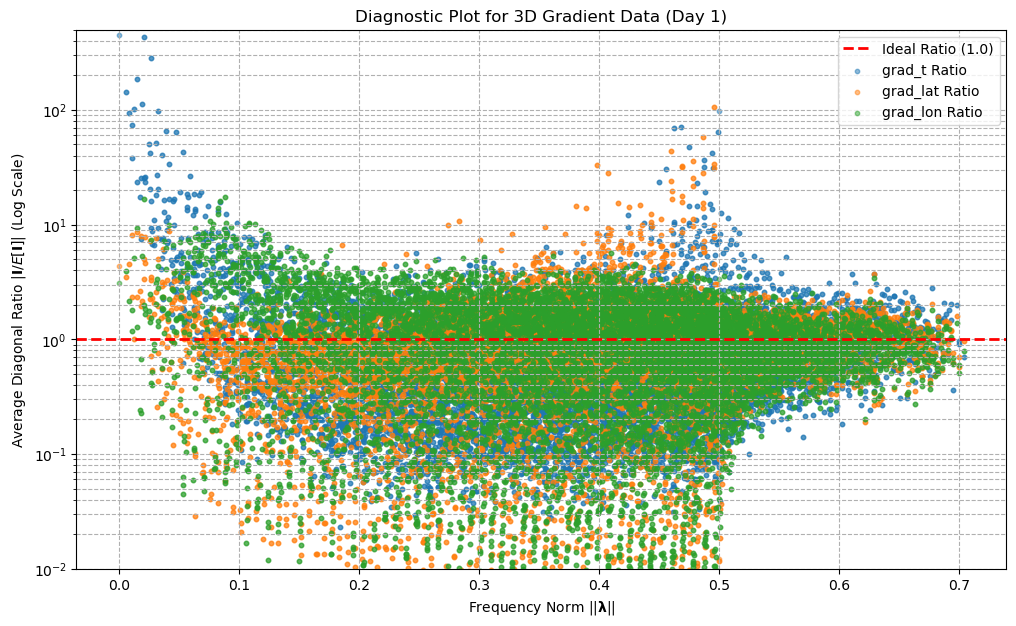

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cmath

# =========================================================================
# 1. Tapering and Modeling Functions
# =========================================================================

def cgn_hamming(u, n1, n2):
    """Computes a 2D Hamming window."""
    u1, u2 = u
    u1_tensor = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_tensor = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1_tensor / n1)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2_tensor / n2)
    return hamming1 * hamming2

def cgn_2dbartlett(u, n1, n2):
    """Computes a 2D Bartlett window function."""
    u1, u2 = u
    return (1 - torch.abs(u1) / n1) * (1 - torch.abs(u2) / n2)

# ✅ --- START: ADDED Analytic Gradient Covariance Functions ---
# These functions model the covariance of the 3D gradient, matching your data.

def get_gradient_covariances_analytic(u1, u2, t, params):
    """
    Computes the autocovariances of the three gradient components analytically.
    NOTE: Assumes params[0, 1, 2, 6] are in LOG-SPACE.
    """
    # 1. Unpack parameters
    sigmasq, r_lat, r_lon, nugget = torch.exp(params[[0, 1, 2, 6]])
    a_lat, a_lon, beta = params[3], params[4], params[5]

    # 2. Calculate the distance term D and the smooth covariance C_smooth
    distance = (u1 / r_lat - a_lat * t)**2 + (u2 / r_lon - a_lon * t)**2 + (beta * t)**2
    C_smooth = sigmasq * torch.exp(-distance)

    # 3. Calculate first partial derivatives of the distance term D
    dD_dt = 2 * (u1 / r_lat - a_lat * t) * (-a_lat) + \
            2 * (u2 / r_lon - a_lon * t) * (-a_lon) + \
            2 * (beta * t) * beta
    dD_du1 = 2 * (u1 / r_lat - a_lat * t) / r_lat
    dD_du2 = 2 * (u2 / r_lon - a_lon * t) / r_lon

    # 4. Calculate second partial derivatives of the distance term D
    d2D_dt2 = 2 * (a_lat**2 + a_lon**2 + beta**2)
    d2D_du1_2 = 2 / r_lat**2
    d2D_du2_2 = 2 / r_lon**2


    # 5. Compute autocovariances
    cov_t = C_smooth * (dD_dt**2 - d2D_dt2)
    cov_lat = C_smooth * (dD_du1**2 - d2D_du1_2)
    cov_lon = C_smooth * (dD_du2**2 - d2D_du2_2)

    # 6. Re-apply nugget effect
    is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
    nugget_effect = 2 * nugget # Simplified effect for first-order difference
    
    cov_t = torch.where(is_zero_lag, cov_t + nugget_effect, cov_t)
    cov_lat = torch.where(is_zero_lag, cov_lat + nugget_effect, cov_lat)
    cov_lon = torch.where(is_zero_lag, cov_lon + nugget_effect, cov_lon)
    
    return cov_t, cov_lat, cov_lon

# Wrapper functions for clarity
def cov_grad_t(u1, u2, t, params):
    return get_gradient_covariances_analytic(u1, u2, t, params)[0]

def cov_grad_lat(u1, u2, t, params):
    return get_gradient_covariances_analytic(u1, u2, t, params)[1]

def cov_grad_lon(u1, u2, t, params):
    return get_gradient_covariances_analytic(u1, u2, t, params)[2]
# ✅ --- END: ADDED Analytic Gradient Covariance Functions ---


# 🔄 MODIFIED: Now takes a `cov_func` argument to be generic
def cn_bar(u1, u2, t, params, n1, n2, tampering_func, cov_func):
    """Computes the tapered covariance for a given component."""
    u = (u1, u2)
    return cov_func(u1, u2, t, params) * tampering_func(u, n1, n2)

# 🔄 MODIFIED: Now takes a `cov_func` argument to work for any component
def expected_periodogram_fft_multivariate(params, n1, n2, p, tampering_func, cov_func):
    """Calculates the expected periodogram for a single gradient component."""
    product_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    t_lags = torch.arange(p, dtype=torch.float32)
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    
    for q in range(p):
        for r in range(p):
            t = t_lags[q] - t_lags[r]
            # Pass the specific covariance function
            product_tensor[:, :, q, r] = cn_bar(u1_mesh, u2_mesh, t, params, n1, n2, tampering_func, cov_func)
            
    fft_result = torch.fft.fft2(product_tensor, dim=(-4, -3))
    normalization_factor = 1 / (2 * cmath.pi)**2
    return fft_result * normalization_factor

# =========================================================================
# 2. Data Processing Functions
# =========================================================================

# 🔄 MODIFIED: `val_col` is now a flexible argument, returns `p`
def generate_Jvector_final(tensor_list, tapering_func, lat_col=0, lon_col=1, val_col=2):
    """Processes data grids into a J-vector using tapering."""
    p = len(tensor_list) # ✅ p is the number of time points
    if p == 0: 
        return torch.empty(0, 0, 0), 0, 0, 0
        
    all_lats = torch.cat([t[:, lat_col] for t in tensor_list])
    all_lons = torch.cat([t[:, lon_col] for t in tensor_list])
    unique_lats, unique_lons = torch.unique(all_lats), torch.unique(all_lons)
    n1, n2 = len(unique_lats), len(unique_lons)
    
    if n1 == 0 or n2 == 0:
        return torch.empty(0, 0, 0), 0, 0, p

    lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
    lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}
    
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    taper_grid = tapering_func((u1_mesh, u2_mesh), n1, n2)
    
    fft_results = []
    for tensor in tensor_list:
        data_grid = torch.zeros((n1, n2), dtype=torch.float32)
        for row in tensor:
             if row[lat_col].item() in lat_map and row[lon_col].item() in lon_map:
                 i, j = lat_map[row[lat_col].item()], lon_map[row[lon_col].item()]
                 data_grid[i, j] = row[val_col] # ✅ Uses the specified val_col
        data_grid_tapered = data_grid * taper_grid
        fft_results.append(torch.fft.fft2(data_grid_tapered))
        
    J_vector_tensor = torch.stack(fft_results, dim=2)
    H = torch.sum(taper_grid**2)
    norm_factor = torch.sqrt(1 / H) / (2 * cmath.pi)
    return J_vector_tensor * norm_factor, n1, n2, p # ✅ Return p

def calculate_sample_periodogram_vectorized(J_vector_tensor):
    """Calculates the sample periodogram matrix from the J-vector."""
    J_col = J_vector_tensor.unsqueeze(-1)
    J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
    return J_col @ J_row_conj

# =========================================================================
# 3. Main Execution Logic for Plotting
# =========================================================================

if __name__ == '__main__':
    # --- IMPORTANT ---
    # ✅ This script now assumes `all_gradient_tensors` (from your first script)
    # is loaded and available in this scope.
    
    # --- Configuration ---
    DAY_TO_RUN = 1
    TAMPERING_FUNC = cgn_2dbartlett
    
    # 🔄 Title reflects the new data
    print(f"--- Day {DAY_TO_RUN} Diagnostic Plot for 3D GRADIENT Data ---")
    
    # --- Define the parameters (in their natural scale) ---
    best_params_list = [7.7046, 1.952, 4.1366, -1.0769, -0.3244, 0.1074, 3.9057]
    print(f"Using pre-defined natural-scale parameters: {best_params_list}")
    
    # ✅ Convert natural-scale params to the log-space params required by the model
    params_natural = torch.tensor(best_params_list, dtype=torch.float32)
    best_params_log = params_natural.clone()
    best_params_log[[0, 1, 2, 6]] = torch.log(params_natural[[0, 1, 2, 6]])
    print(f"Using log-space params for model: {best_params_log.numpy().round(4)}")
    
    # --- Data Preparation ---
    # 🔄 Load the pre-processed 3D gradient data
    cur_df = all_gradient_tensors[DAY_TO_RUN - 1]
    unique_times = torch.unique(cur_df[:, 2])
    tensor_list = [cur_df[cur_df[:, 2] == t_val] for t_val in unique_times]
    
    # --- Calculation for all 3 components ---
    p = len(tensor_list)
    if p == 0:
        print("No data for this day.")
    else:
        # ✅ --- Component 1: grad_t ---
        print("Processing grad_t...")
        J_vec_t, n1, n2, p = generate_Jvector_final(tensor_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=3) # val_col=3
        I_sample_t = calculate_sample_periodogram_vectorized(J_vec_t)
        I_expected_t = expected_periodogram_fft_multivariate(best_params_log, n1, n2, p, TAMPERING_FUNC, cov_grad_t)

        # ✅ --- Component 2: grad_lat ---
        print("Processing grad_lat...")
        J_vec_lat, _, _, _ = generate_Jvector_final(tensor_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=4) # val_col=4
        I_sample_lat = calculate_sample_periodogram_vectorized(J_vec_lat)
        I_expected_lat = expected_periodogram_fft_multivariate(best_params_log, n1, n2, p, TAMPERING_FUNC, cov_grad_lat)
        
        # ✅ --- Component 3: grad_lon ---
        print("Processing grad_lon...")
        J_vec_lon, _, _, _ = generate_Jvector_final(tensor_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=5) # val_col=5
        I_sample_lon = calculate_sample_periodogram_vectorized(J_vec_lon)
        I_expected_lon = expected_periodogram_fft_multivariate(best_params_log, n1, n2, p, TAMPERING_FUNC, cov_grad_lon)

        print(f"Data grid: {n1}x{n2} spatial points, {p} time points.")

        # --- Plotting ---
        I_sample_t_s = torch.fft.fftshift(I_sample_t, dim=(-4, -3))
        I_expected_t_s = torch.fft.fftshift(I_expected_t, dim=(-4, -3))
        I_sample_lat_s = torch.fft.fftshift(I_sample_lat, dim=(-4, -3))
        I_expected_lat_s = torch.fft.fftshift(I_expected_lat, dim=(-4, -3))
        I_sample_lon_s = torch.fft.fftshift(I_sample_lon, dim=(-4, -3))
        I_expected_lon_s = torch.fft.fftshift(I_expected_lon, dim=(-4, -3))
        
        epsilon = 1e-15
        
        # ✅ Calculate ratios for all 3 components
        ratio_t = torch.diagonal(I_sample_t_s / (I_expected_t_s + epsilon), dim1=-2, dim2=-1) 
        ratio_t_avg = torch.mean(torch.abs(ratio_t), dim=-1)
        
        ratio_lat = torch.diagonal(I_sample_lat_s / (I_expected_lat_s + epsilon), dim1=-2, dim2=-1) 
        ratio_lat_avg = torch.mean(torch.abs(ratio_lat), dim=-1)
        
        ratio_lon = torch.diagonal(I_sample_lon_s / (I_expected_lon_s + epsilon), dim1=-2, dim2=-1) 
        ratio_lon_avg = torch.mean(torch.abs(ratio_lon), dim=-1)
        
        # --- Frequency Grid (Unchanged) ---
        freq_lat, freq_lon = np.fft.fftfreq(n1), np.fft.fftfreq(n2)
        freq_lon_shifted, freq_lat_shifted = np.fft.fftshift(freq_lon), np.fft.fftshift(freq_lat)
        
        freq_grid_lon, freq_grid_lat = np.meshgrid(freq_lon_shifted, freq_lat_shifted)
        frequency_norm = np.sqrt(freq_grid_lat**2 + freq_grid_lon**2)
        
        norm_flat = frequency_norm.flatten()
        
        # ✅ Flatten all 3 ratio components
        ratio_t_flat = ratio_t_avg.detach().numpy().flatten()
        ratio_lat_flat = ratio_lat_avg.detach().numpy().flatten()
        ratio_lon_flat = ratio_lon_avg.detach().numpy().flatten()

        # 🔄 Modified Plot
        plt.figure(figsize=(12, 7))
        plt.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal Ratio (1.0)')
        
        # ✅ Plot all 3 components
        plt.scatter(norm_flat, ratio_t_flat, s=10, alpha=0.5, label='grad_t Ratio')
        plt.scatter(norm_flat, ratio_lat_flat, s=10, alpha=0.5, label='grad_lat Ratio')
        plt.scatter(norm_flat, ratio_lon_flat, s=10, alpha=0.5, label='grad_lon Ratio')
        
        plt.yscale('log')
        plt.ylim(1e-2, 5e2)
        # 🔄 Updated title
        plt.title(f'Diagnostic Plot for 3D Gradient Data (Day {DAY_TO_RUN})')
        plt.xlabel(r'Frequency Norm $||\boldsymbol{\lambda}||$')
        plt.ylabel(r'Average Diagonal Ratio $|\mathbf{I} / E[\mathbf{I}]|$ (Log Scale)')
        plt.legend()
        plt.grid(True, which="both", ls="--")
        
        # 🔄 Updated stats printout
        print("\nRatio Statistics:")
        print(f"  grad_t:  Max={np.max(ratio_t_flat):.2e}, Min={np.min(ratio_t_flat):.2e}, Mean={np.mean(ratio_t_flat):.2f}")
        print(f"  grad_lat: Max={np.max(ratio_lat_flat):.2e}, Min={np.min(ratio_lat_flat):.2e}, Mean={np.mean(ratio_lat_flat):.2f}")
        print(f"  grad_lon: Max={np.max(ratio_lon_flat):.2e}, Min={np.min(ratio_lon_flat):.2e}, Mean={np.mean(ratio_lon_flat):.2f}")
        
        plt.show()

In [33]:
import torch
import numpy as np
import cmath
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.nn import Parameter
from typing import Callable
import pickle

# =========================================================================
# 1. Tapering and Modeling Functions
# =========================================================================

def cgn_hamming(u, n1, n2):
    """Computes a 2D Hamming window."""
    u1, u2 = u
    u1_tensor = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_tensor = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1_tensor / n1)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2_tensor / n2)
    return hamming1 * hamming2

def cgn_2dbartlett(u, n1, n2):
    """Computes a 2D Bartlett window function."""
    u1, u2 = u
    return (1 - torch.abs(u1) / n1) * (1 - torch.abs(u2) / n2)

# 🔄 --- UPDATED RANDOM INITIALIZATION FUNCTION ---
def get_random_initial_params():
    """
    Generates a list of 7 random initial parameter values from user-specified ranges.
    Returns values for:
    [log(sigmasq), log(r_lat), log(r_lon), a_lat, a_lon, beta, log(nugget)]
    """
    # Uses the exact ranges you provided
    initial_params_values = [
        np.log(np.random.uniform(7, 30)),      # log(sigmasq)
        np.log(np.random.uniform(0.5, 4.0)),   # log(range_lat)
        np.log(np.random.uniform(0.5, 4.0)),   # log(range_lon)
        np.random.uniform(-0.03, 0.03),        # advec_lat
        np.random.uniform(-0.08, -0.01),       # advec_lon
        np.random.uniform(0.1, 0.5),           # beta
        np.log(np.random.uniform(1.0, 5.0))    # log(nugget)
    ]
    return initial_params_values
# 🔄 --- END UPDATED FUNCTION ---

def get_gradient_covariances_analytic(u1, u2, t, params):
    """
    Computes the autocovariances of the three gradient components analytically
    using an EXPONENTIAL kernel for the underlying smooth field.

    Args:
        params: A single concatenated tensor of parameters (shape [7,]).
    """
    # 1. Unpack parameters (Same as before)
    sigmasq, r_lat, r_lon, nugget = torch.exp(params[[0, 1, 2, 6]])
    a_lat, a_lon, beta = params[3], params[4], params[5]

    # --- Calculations for the Exponential Kernel ---

    # 2a. Calculate components and the *squared* distance D^2 (for intermediate steps)
    x1 = u1 / r_lat - a_lat * t
    x2 = u2 / r_lon - a_lon * t
    x3 = beta * t
    distance_sq = x1**2 + x2**2 + x3**2
    epsilon = 1e-12 # For numerical stability near zero lag
    distance_sq = distance_sq + epsilon # Add epsilon before sqrt

    # 2b. Calculate the actual distance D = sqrt(D^2) <<< CHANGED (kept from your last version)
    D = torch.sqrt(distance_sq)

    # 2c. Calculate the smooth covariance C_smooth using Exponential kernel <<< CHANGED
    C_smooth = sigmasq * torch.exp(-D)

    # 3. Calculate first partial derivatives *of D* (not D^2) <<< CHANGED
    # dD/dh = (1/D) * (x1*dx1/dh + x2*dx2/dh + x3*dx3/dh)
    dD_dt = (1 / D) * (x1 * (-a_lat) + x2 * (-a_lon) + x3 * beta)
    dD_du1 = (1 / D) * (x1 / r_lat)
    dD_du2 = (1 / D) * (x2 / r_lon)

    # 4. Calculate terms needed for second partial derivatives *of D* <<< CHANGED
    # d^2(D^2)/dh^2 (Second derivative of the squared distance)
    d2_Dsq_dt2 = 2 * (a_lat**2 + a_lon**2 + beta**2)
    d2_Dsq_du1_2 = 2 / r_lat**2
    d2_Dsq_du2_2 = 2 / r_lon**2

    # d^2D/dh^2 = (1/D) * ( (1/2)*d^2(D^2)/dh^2 - (dD/dh)^2 )
    d2D_dt2 = (1 / D) * (0.5 * d2_Dsq_dt2 - dD_dt**2)
    d2D_du1_2 = (1 / D) * (0.5 * d2_Dsq_du1_2 - dD_du1**2)
    d2D_du2_2 = (1 / D) * (0.5 * d2_Dsq_du2_2 - dD_du2**2)

    # 5. Compute autocovariances using the CORRECTED formula for gradient:
    # Cov(grad_i) = C_smooth * ( d2D/dh_i^2 - (dD/dh_i)^2 ) <<< CHANGED
    # Note the sign flip from your original code.
    cov_t = C_smooth * (d2D_dt2 - dD_dt**2)
    cov_lat = C_smooth * (d2D_du1_2 - dD_du1**2)
    cov_lon = C_smooth * (d2D_du2_2 - dD_du2**2)

    # --- End of Exponential Kernel Calculations ---

    # 6. Re-apply nugget effect (Same as before, still correct)
    is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
    nugget_effect = 2 * nugget

    # Use torch.where to add nugget only at zero lag
    cov_t = torch.where(is_zero_lag, cov_t + nugget_effect, cov_t)
    cov_lat = torch.where(is_zero_lag, cov_lat + nugget_effect, cov_lat)
    cov_lon = torch.where(is_zero_lag, cov_lon + nugget_effect, cov_lon)

    return cov_t, cov_lat, cov_lon

# Wrapper functions 
def cov_grad_t(u1, u2, t, params):
    # Wrapper to concatenate list of params back into a single tensor
    params_cat = torch.cat(params)
    return get_gradient_covariances_analytic(u1, u2, t, params_cat)[0]

def cov_grad_lat(u1, u2, t, params):
    params_cat = torch.cat(params)
    return get_gradient_covariances_analytic(u1, u2, t, params_cat)[1]

def cov_grad_lon(u1, u2, t, params):
    params_cat = torch.cat(params)
    return get_gradient_covariances_analytic(u1, u2, t, params_cat)[2]

def cn_bar(u1, u2, t, params, n1, n2, tampering_func, cov_func):
    """Computes the tapered covariance for a given component."""
    u = (u1, u2)
    return cov_func(u1, u2, t, params) * tampering_func(u, n1, n2)

def expected_periodogram_fft_multivariate(params, n1, n2, p, tampering_func, cov_func):
    """Calculates the expected periodogram for a single gradient component."""
    product_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    t_lags = torch.arange(p, dtype=torch.float32)
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    
    for q in range(p):
        for r in range(p):
            t = t_lags[q] - t_lags[r]
            product_tensor[:, :, q, r] = cn_bar(u1_mesh, u2_mesh, t, params, n1, n2, tampering_func, cov_func)
            
    fft_result = torch.fft.fft2(product_tensor, dim=(-4, -3))
    normalization_factor = 1 / (2 * cmath.pi)**2
    return fft_result * normalization_factor

# =========================================================================
# 2. Data Processing and Likelihood Calculation
# =========================================================================
def generate_Jvector_final(tensor_list, tapering_func, lat_col, lon_col, val_col):
    p = len(tensor_list)
    if p == 0: return torch.empty(0, 0, 0), 0, 0, 0
    all_lats = torch.cat([t[:, lat_col] for t in tensor_list])
    all_lons = torch.cat([t[:, lon_col] for t in tensor_list])
    unique_lats, unique_lons = torch.unique(all_lats), torch.unique(all_lons)
    n1, n2 = len(unique_lats), len(unique_lons)
    lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
    lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    taper_grid = tapering_func((u1_mesh, u2_mesh), n1, n2)
    
    fft_results = []
    for tensor in tensor_list:
        data_grid = torch.zeros((n1, n2), dtype=torch.float32)
        for row in tensor:
             i, j = lat_map[row[lat_col].item()], lon_map[row[lon_col].item()]
             data_grid[i, j] = row[val_col]
        data_grid_tapered = data_grid * taper_grid
        fft_results.append(torch.fft.fft2(data_grid_tapered))
        
    J_vector_tensor = torch.stack(fft_results, dim=2)
    H = torch.sum(taper_grid**2)
    norm_factor = torch.sqrt(1 / H) / (2 * cmath.pi)
    return J_vector_tensor * norm_factor, n1, n2, p

def calculate_sample_periodogram_vectorized(J_vector_tensor):
    J_col = J_vector_tensor.unsqueeze(-1)
    J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
    return J_col @ J_row_conj

def whittle_likelihood_loss(params, I_samples, n1, n2, p, tampering_func):
    """
    Calculates the joint Whittle likelihood by summing the losses for each
    (assumed independent) gradient component.
    
    Args:
        params: A list of Parameter objects (7 elements).
    """
    I_sample_t, I_sample_lat, I_sample_lon = I_samples
    cov_funcs = [cov_grad_t, cov_grad_lat, cov_grad_lon]
    total_loss = 0

    for i in range(3): # Iterate through the three components
        I_sample_component = I_samples[i]
        cov_func_component = cov_funcs[i]
        
        # params is passed as the list of Parameter objects
        I_expected = expected_periodogram_fft_multivariate(params, n1, n2, p, tampering_func, cov_func_component)
        # Add a small value to the diagonal for numerical stability
        I_expected += torch.eye(p, dtype=torch.complex64, device=I_expected.device) * 1e-9
        
        sign, logabsdet = torch.linalg.slogdet(I_expected)
        log_det_term = logabsdet
        trace_term = torch.einsum('...ii->...', torch.linalg.solve(I_expected, I_sample_component)).real
        
        # Sum over non-zero frequencies
        loss_component = torch.sum(log_det_term[1:, 1:] + trace_term[1:, 1:])
        total_loss += loss_component
        
    return total_loss

# =========================================================================
# 3. Training Loop
# =========================================================================
# =========================================================================
# 3. Training Loop (CORRECTED)
# =========================================================================
def run_full(params_list, optimizer, scheduler, I_sample, n1, n2, p, tampering_func, epochs=600):
    best_loss = float('inf')
    # ✅ Initialize best_params_state with the STARTING parameters
    # This handles the case where epoch 0 might have the best loss before any steps.
    best_params_state = [p.detach().clone() for p in params_list]
    epochs_completed = 0 # Track how many epochs actually ran

    # --- Helper to print parameters in natural scale ---
    def get_printable_params(p_list):
        # Detach and clone to avoid modifying the parameters being optimized
        p_cat = torch.cat([p.detach().clone() for p in p_list])
        # Convert log-transformed params back to natural scale for printing
        p_cat[[0, 1, 2, 6]] = torch.exp(p_cat[[0, 1, 2, 6]])
        return p_cat.numpy().round(4)

    for epoch in range(epochs):
        epochs_completed = epoch + 1 # Increment at the start of the loop
        optimizer.zero_grad()
        loss = whittle_likelihood_loss(params_list, I_sample, n1, n2, p, tampering_func)

        # --- Check for NaN/Inf Loss ---
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss became NaN or Inf at epoch {epoch+1}. Stopping.")
            # Indicate failure by setting best_loss back to infinity if it happened early
            if best_loss == float('inf'):
                 best_params_state = None # No valid state found
            epochs_completed = epoch # Record epochs *before* failure
            break # Exit the loop

        # --- Backpropagation and Gradient Clipping ---
        loss.backward()
        torch.nn.utils.clip_grad_norm_([p for group in optimizer.param_groups for p in group['params']], max_norm=1.0)

        # --- Optimizer and Scheduler Step ---
        optimizer.step() # Update parameters FIRST
        scheduler.step() # Update learning rate AFTER optimizer step

        # --- ✅ Moved Check: Save Best State AFTER Stepping ---
        # Now check if the loss calculated at the *beginning* of this epoch
        # (using parameters from the *previous* epoch's end)
        # is the best one seen so far. If so, save the *current* parameters
        # (which were just updated by optimizer.step()).
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params_state = [p.detach().clone() for p in params_list]
        # --- End Moved Check ---

        current_lr = optimizer.param_groups[0]['lr'] # Get current LR for logging

        # --- Logging ---
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f'--- Epoch {epoch+1}/{epochs} (LR: {current_lr:.6f}) ---')
            print(f' Loss: {loss.item():.4f}')
            # Print parameters *after* the step for this epoch
            print(f' Parameters (Natural Scale): {get_printable_params(params_list)}')

        # --- Convergence Check (Optional but good practice) ---
        # Note: Convergence check might stop before reaching the absolute best minimum,
        # especially with cosine annealing. Consider adjusting tolerance or removing.
        # tol = 1e-5 # Example tolerance
        # if epoch > 0 and abs(prev_loss - loss.item()) < tol:
        #     print(f"Loss change below tolerance {tol} at epoch {epoch+1}. Considering converged.")
        #     break
        # prev_loss = loss.item()

    # --- Final Reporting ---
    print("\n--- Training Complete ---")
    if best_params_state is None:
        print("Training failed to find a valid model state (NaN/Inf loss encountered early).")
        return None, epochs_completed

    # Prepare final output using the correctly saved best state
    final_params_log_scale = torch.cat(best_params_state)
    final_params_natural_scale = final_params_log_scale.detach().clone()
    final_params_natural_scale[[0, 1, 2, 6]] = torch.exp(final_params_natural_scale[[0, 1, 2, 6]])

    final_params_rounded = [round(p, 4) for p in final_params_natural_scale.tolist()]
    final_loss_rounded = round(best_loss, 3) # Use more precision for loss if needed

    print(f'\nFINAL BEST STATE ACHIEVED (during training):')
    print(f'Best Loss: {final_loss_rounded}')
    print(f'Parameters Corresponding to Best Loss (Natural Scale): {final_params_rounded}')

    # Return the best parameters found (natural scale) and the best loss
    return final_params_rounded + [final_loss_rounded], epochs_completed

# =========================================================================
# 4. Main Execution Script (Final Integration and Correction)
# =========================================================================
if __name__ == '__main__':
    # --- This script assumes `all_gradient_tensors` is loaded and available.
    
    # --- Configuration ---
    DAY_TO_RUN = 1 
    TAMPERING_FUNC = cgn_2dbartlett
    N_INITIALIZATIONS = 1 # ✅ Run 10 times
    EPOCHS = 600           # Epochs *per run*

    # --- Data Preparation (Done ONCE) ---
    # NOTE: DUMMY DATA CREATION FOR DEMO. REPLACE WITH YOUR ACTUAL DATA LOADING.
    # Assuming the data structure is [lat_coord(0), lon_coord(1), time_idx(2), grad_t(3), grad_lat(4), grad_lon(5)]
    if 'all_gradient_tensors' not in locals():
        print("NOTE: Using DUMMY DATA for demonstration. Load your actual 'all_gradient_tensors' data before running.")
        dummy_data = torch.randn(5000, 6)
        dummy_data[:, 2] = torch.randint(20, 30, (5000,), dtype=torch.float32) 
        all_gradient_tensors = [dummy_data]
        
    cur_df = all_gradient_tensors[DAY_TO_RUN - 1].to(torch.float32)
    unique_times = torch.unique(cur_df[:, 2]) 
    time_slices_list = [cur_df[cur_df[:, 2] == t_val] for t_val in unique_times]

    # --- 1. Pre-compute Sample Periodograms (Done ONCE) ---
    print("Pre-computing sample periodograms for each gradient component...")
    
    J_vec_t, n1, n2, p = generate_Jvector_final(time_slices_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=3)
    I_sample_t = calculate_sample_periodogram_vectorized(J_vec_t)

    J_vec_lat, _, _, _ = generate_Jvector_final(time_slices_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=4)
    I_sample_lat = calculate_sample_periodogram_vectorized(J_vec_lat)
    
    J_vec_lon, _, _, _ = generate_Jvector_final(time_slices_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=5)
    I_sample_lon = calculate_sample_periodogram_vectorized(J_vec_lon)

    I_samples = [I_sample_t, I_sample_lat, I_sample_lon]
    print(f"Data grid: {n1}x{n2} spatial points, {p} time points.")

    # --- 2. Setup Optimization and Training Loop ---
    
    all_final_results = []
    all_final_losses = []

    for i in range(N_INITIALIZATIONS):
        print(f"\n{'='*30} Initialization Run {i+1}/{N_INITIALIZATIONS} {'='*30}")
        
        # --- 2a. Get random initial parameters for this run (using your new ranges) ---
        initial_params_values = get_random_initial_params()
        print(f"Starting with random params (log-scale for some): {[round(p, 4) for p in initial_params_values]}")
        
        # 🔄 This loop correctly creates a list of Parameter objects, each with shape [1]
        
        initial_params_values = [np.log(25), np.log(1),np.log(1.5), -0.05, -0.08, 0.05, np.log(2)]
        params_list = [
            Parameter(torch.tensor([val], dtype=torch.float32)) 
            for val in initial_params_values
        ]

        # --- 2b. Re-create optimizer and scheduler for this run ---
        lr_slow, lr_fast = 0.005, 0.03
        slow_indices = [0, 1, 2]  # Variance, Ranges, Nugget (Log-transformed)
        fast_indices = [3, 4, 5, 6 ]     # Advection, Temporal Scaling (Linear scale)
        
        param_groups = [
            {'params': [params_list[i] for i in slow_indices], 'lr': lr_slow, 'name': 'slow_group'}, 
            {'params': [params_list[i] for i in fast_indices], 'lr': lr_fast, 'name': 'fast_group'}
        ]
        
        optimizer = torch.optim.Adam(param_groups)
        
        T_MAX = EPOCHS 
        ETA_MIN = 1e-4
        scheduler = CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=ETA_MIN)

        # --- 3. Run Training ---
        print(f"Starting optimization run {i+1}...")
        final_results, epochs_run = run_full(
            params_list=params_list,
            optimizer=optimizer,
            scheduler=scheduler,
            I_sample=I_samples,
            n1=n1, n2=n2, p=p,
            tampering_func=TAMPERING_FUNC,
            epochs=EPOCHS
        )
        
        # --- 4. Store results ---
        if final_results:
            all_final_results.append(final_results)
            all_final_losses.append(final_results[-1]) # Last element is the loss
        else:
            all_final_results.append(None)
            all_final_losses.append(float('inf'))


    # --- 5. Report the Final Best Result ---
    print(f"\n\n{'='*25} Overall Best Result from {N_INITIALIZATIONS} Runs {'='*25}")
    
    if not all_final_losses or all(l == float('inf') for l in all_final_losses):
        print(f"All {N_INITIALIZATIONS} initialization runs failed for Day {DAY_TO_RUN}.")
    else:
        best_loss = min(all_final_losses)
        best_run_index = all_final_losses.index(best_loss)
        best_results = all_final_results[best_run_index]
        
        print(f"Best run was #{best_run_index + 1}")
        print(f"Final Loss: {best_results[-1]}")
        print(f"Final Parameters (Natural Scale): {best_results[:-1]}")



Pre-computing sample periodograms for each gradient component...
Data grid: 256x256 spatial points, 7 time points.

============================== Initialization Run 1/1 ==============================
Starting with random params (log-scale for some): [2.0539, 0.9162, 0.6288, 0.0128, -0.0431, 0.4689, 1.3111]
Starting optimization run 1...
--- Epoch 1/600 (LR: 0.005000) ---
 Loss: 15835946.0000
 Parameters (Natural Scale): [ 2.48753e+01  1.00500e+00  1.50750e+00 -2.00000e-02 -5.00000e-02
  2.00000e-02  1.94160e+00]
--- Epoch 101/600 (LR: 0.004665) ---
 Loss: 11730894.0000
 Parameters (Natural Scale): [ 2.08917e+01  1.19880e+00  1.79830e+00  2.20000e-03 -1.00000e-04
 -2.20000e-03  1.77900e-01]
--- Epoch 201/600 (LR: 0.003764) ---
 Loss: 11338234.0000
 Parameters (Natural Scale): [ 1.91251e+01  1.31740e+00  1.97610e+00  1.40000e-03  0.00000e+00
 -1.30000e-03  5.89000e-02]
--- Epoch 301/600 (LR: 0.002537) ---
 Loss: 11518160.0000
 Parameters (Natural Scale): [ 1.74277e+01  1.46030e+00  2.19

In [4]:
import torch
import numpy as np
import cmath
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.nn import Parameter
from typing import Callable, List, Tuple
import pickle
import time # Optional: For timing runs

# =========================================================================
# 1. Tapering and Helper Functions (Unchanged)
# =========================================================================

def cgn_hamming(u, n1, n2):
    """Computes a 2D Hamming window."""
    u1, u2 = u
    u1_tensor = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_tensor = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    if isinstance(u1, torch.Tensor):
        dev = u1.device
        u1_tensor = u1_tensor.to(dev)
        u2_tensor = u2_tensor.to(dev)
    n1_eff = n1 if n1 > 0 else 1.0
    n2_eff = n2 if n2 > 0 else 1.0
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1_tensor / n1_eff)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2_tensor / n2_eff)
    return hamming1 * hamming2

def cgn_2dbartlett(u, n1, n2):
    """Computes a 2D Bartlett window function."""
    u1, u2 = u
    u1_tensor = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_tensor = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    if isinstance(u1, torch.Tensor):
        dev = u1.device
        u1_tensor = u1_tensor.to(dev)
        u2_tensor = u2_tensor.to(dev)
    n1_eff = n1 if n1 > 0 else 1.0
    n2_eff = n2 if n2 > 0 else 1.0
    return (1 - torch.abs(u1_tensor) / n1_eff) * (1 - torch.abs(u2_tensor) / n2_eff)

# (get_random_initial_params is kept for potential future use but not called in main)
def get_random_initial_params():
    """
    Generates a list of 7 random initial parameter values from user-specified ranges.
    Returns values for:
    [log(sigmasq), log(r_lat), log(r_lon), a_lat, a_lon, beta, log(nugget)]
    """
    initial_params_values = [
        np.log(np.random.uniform(7, 30)),      # log(sigmasq)
        np.log(np.random.uniform(0.5, 4.0)),   # log(range_lat)
        np.log(np.random.uniform(0.5, 4.0)),   # log(range_lon)
        np.random.uniform(-0.03, 0.03),        # advec_lat
        np.random.uniform(-0.08, -0.01),       # advec_lon
        np.random.uniform(0.1, 0.5),           # beta
        np.log(np.random.uniform(1.0, 5.0))    # log(nugget)
    ]
    return initial_params_values

# =========================================================================
# 2. Multivariate Covariance and Spectral Density (NEW/MODIFIED)
# =========================================================================

def get_gradient_covariances_analytic_multivariate(u1, u2, t, params):
    """
    Computes the 3x3 cross-covariance matrix of the gradient components
    analytically using an EXPONENTIAL kernel for the underlying smooth field.
    Indices: 0=t, 1=lat(u1), 2=lon(u2)

    Args:
        params: A single concatenated tensor of parameters (shape [7,]).
                Assumed to be on the correct device.
        u1, u2, t: Lag tensors (can be scalars or meshes).

    Returns:
        A torch.Tensor of shape [..., 3, 3] representing the cross-covariance matrix.
    """
    # 1. Unpack parameters
    sigmasq, r_lat, r_lon, nugget = torch.exp(params[[0, 1, 2, 6]])
    a_lat, a_lon, beta = params[3], params[4], params[5]

    # --- Calculations for the Exponential Kernel ---
    x1 = u1 / r_lat - a_lat * t
    x2 = u2 / r_lon - a_lon * t
    x3 = beta * t
    distance_sq = x1**2 + x2**2 + x3**2
    epsilon = 1e-12 # For numerical stability near zero lag

    distance_sq = torch.clamp(distance_sq, min=0.0)
    D = torch.sqrt(distance_sq + epsilon) # Add epsilon inside sqrt

    C_smooth = sigmasq * torch.exp(-D)

    # 3. First partial derivatives of D
    inv_D = 1.0 / D
    dD_dt = inv_D * (x1 * (-a_lat) + x2 * (-a_lon) + x3 * beta)
    dD_du1 = inv_D * (x1 / r_lat)
    dD_du2 = inv_D * (x2 / r_lon)
    first_derivs_D = torch.stack([dD_dt, dD_du1, dD_du2], dim=-1) # Shape [..., 3]

    # 4. Second partial derivatives of D (Pure and Mixed)
    d2_Dsq_dt2 = 2 * (a_lat**2 + a_lon**2 + beta**2)
    d2_Dsq_du1_2 = 2 / r_lat**2
    d2_Dsq_du2_2 = 2 / r_lon**2
    d2_Dsq_dt_du1 = -2 * a_lat / r_lat
    d2_Dsq_dt_du2 = -2 * a_lon / r_lon
    d2_Dsq_du1_du2 = torch.zeros_like(d2_Dsq_dt_du1) # Shape needs to match others

    outer_first_derivs = first_derivs_D.unsqueeze(-1) * first_derivs_D.unsqueeze(-2) # Shape [..., 3, 3]

    d2D_dt2 = inv_D * (0.5 * d2_Dsq_dt2 - outer_first_derivs[..., 0, 0])
    d2D_du1_2 = inv_D * (0.5 * d2_Dsq_du1_2 - outer_first_derivs[..., 1, 1])
    d2D_du2_2 = inv_D * (0.5 * d2_Dsq_du2_2 - outer_first_derivs[..., 2, 2])
    d2D_dt_du1 = inv_D * (0.5 * d2_Dsq_dt_du1 - outer_first_derivs[..., 0, 1])
    d2D_dt_du2 = inv_D * (0.5 * d2_Dsq_dt_du2 - outer_first_derivs[..., 0, 2])
    d2D_du1_du2 = inv_D * (0.5 * d2_Dsq_du1_du2 - outer_first_derivs[..., 1, 2])

    hessian_D = torch.zeros(D.shape + (3, 3), device=D.device, dtype=D.dtype)
    hessian_D[..., 0, 0] = d2D_dt2
    hessian_D[..., 1, 1] = d2D_du1_2
    hessian_D[..., 2, 2] = d2D_du2_2
    hessian_D[..., 0, 1] = hessian_D[..., 1, 0] = d2D_dt_du1
    hessian_D[..., 0, 2] = hessian_D[..., 2, 0] = d2D_dt_du2
    hessian_D[..., 1, 2] = hessian_D[..., 2, 1] = d2D_du1_du2

    # 5. Compute 3x3 cross-covariance matrix C_Y
    C_Y = C_smooth.unsqueeze(-1).unsqueeze(-1) * (hessian_D - outer_first_derivs)

    # 6. Re-apply nugget effect
    is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)

    if torch.any(is_zero_lag):
        nugget_effect_matrix_diag = torch.eye(3, device=params.device, dtype=params.dtype) * (2 * nugget)
        nugget_effect_matrix_expanded = nugget_effect_matrix_diag.expand(C_Y.shape)
        C_Y = torch.where(is_zero_lag.unsqueeze(-1).unsqueeze(-1),
                          C_Y + nugget_effect_matrix_expanded,
                          C_Y)

    return C_Y

# --- NEW Wrapper for the 3x3 Covariance Matrix ---
def cov_grad_matrix(u1, u2, t, params):
    """
    Wrapper to get the 3x3 cross-covariance matrix.
    params is expected to be a list of Parameter objects.
    Concatenates parameters and calls the multivariate analytic function.
    """
    device = params[0].device
    params_cat = torch.cat([p.to(device) for p in params])
    # Ensure lag inputs are tensors and on the same device
    u1_dev = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_dev = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    t_dev = t if isinstance(t, torch.Tensor) else torch.tensor(t, dtype=torch.float32)
    # Move lags to device if they aren't already there
    u1_dev, u2_dev, t_dev = u1_dev.to(device), u2_dev.to(device), t_dev.to(device)

    return get_gradient_covariances_analytic_multivariate(u1_dev, u2_dev, t_dev, params_cat)

# --- Modified Tapered Covariance Function ---
def cn_bar_matrix(u1, u2, t, params, n1, n2, tampering_func, matrix_cov_func):
    """Computes the tapered 3x3 cross-covariance matrix."""
    u = (u1, u2)
    device = params[0].device
    # Ensure u1, u2 for tapering are on the correct device
    u1_dev = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_dev = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    u1_dev, u2_dev = u1_dev.to(device), u2_dev.to(device)

    taper_value = tampering_func((u1_dev, u2_dev), n1, n2)
    # Call matrix_cov_func which handles internal device placement
    cov_matrix = matrix_cov_func(u1, u2, t, params)
    # Ensure taper_value broadcasts correctly and is on the same device as cov_matrix
    return cov_matrix * taper_value.unsqueeze(-1).unsqueeze(-1).to(cov_matrix.device)

# --- Modified Expected Periodogram Function ---
def expected_periodogram_fft_multivariate_matrix(params, n1, n2, p, tampering_func, matrix_cov_func):
    """
    Calculates the expected 3x3 spectral density matrix I(omega; theta).
    """
    device = params[0].device

    product_tensor = torch.zeros((n1, n2, p, p, 3, 3), dtype=torch.complex64, device=device)
    t_lags = torch.arange(p, dtype=torch.float32, device=device)
    u1_mesh, u2_mesh = torch.meshgrid(
        torch.arange(n1, dtype=torch.float32, device=device),
        torch.arange(n2, dtype=torch.float32, device=device),
        indexing='ij'
    )

    for q in range(p):
        for r in range(p):
            t_diff = t_lags[q] - t_lags[r] # Scalar tensor on device
            # cn_bar_matrix handles device internally for taper and cov_func
            tapered_cov_matrix = cn_bar_matrix(
                u1_mesh, u2_mesh, t_diff,
                params, n1, n2, tampering_func, matrix_cov_func
            ) # Shape [n1, n2, 3, 3] on device
            product_tensor[:, :, q, r, :, :] = tapered_cov_matrix.to(torch.complex64)

    fft_result = torch.fft.fft2(product_tensor, dim=(-6, -5)) # FFT over n1, n2
    normalization_factor = 1 / (2 * cmath.pi)**2
    return fft_result * normalization_factor


# =========================================================================
# 3. Data Processing (NEW/MODIFIED)
# =========================================================================

def generate_Jvectors_stacked(tensor_list, tapering_func, lat_col, lon_col, val_cols, device):
    """
    Generates stacked J-vectors (DFT vectors) for multiple value columns
    and places results on the specified device.
    """
    p = len(tensor_list)
    num_components = len(val_cols)
    if p == 0: return torch.empty(0, 0, 0, 0, device=device), 0, 0, 0

    valid_tensors = [t for t in tensor_list if t.numel() > 0]
    if not valid_tensors:
         return torch.empty(0, 0, 0, 0, device=device), 0, 0, 0

    all_lats = torch.cat([t[:, lat_col] for t in valid_tensors])
    all_lons = torch.cat([t[:, lon_col] for t in valid_tensors])
    unique_lats, unique_lons = torch.unique(all_lats), torch.unique(all_lons)
    n1, n2 = len(unique_lats), len(unique_lons)
    lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
    lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}

    u1_mesh, u2_mesh = torch.meshgrid(
        torch.arange(n1, dtype=torch.float32),
        torch.arange(n2, dtype=torch.float32),
        indexing='ij'
    )
    taper_grid = tapering_func((u1_mesh, u2_mesh), n1, n2).to(device)

    all_fft_results_stacked = []

    for tensor in tensor_list: # Loop through time points (CPU tensors)
        # Create data grids on the target device directly
        data_grid = torch.zeros((num_components, n1, n2), dtype=torch.float32, device=device)

        if tensor.numel() > 0: # Check if tensor for this time slice is empty
            # Process rows on CPU then move result, or move tensor chunk to GPU
            # Moving tensor chunk is likely faster if device is GPU
            tensor_dev = tensor.to(device)
            for row in tensor_dev:
                lat_item, lon_item = row[lat_col].item(), row[lon_col].item()
                if not (np.isnan(lat_item) or np.isnan(lon_item) or np.isinf(lat_item) or np.isinf(lon_item)):
                    # Use .get() for safer dictionary access
                    i = lat_map.get(lat_item)
                    j = lon_map.get(lon_item)
                    if i is not None and j is not None:
                       data_grid[:, i, j] = row[val_cols] # Assign all val_cols at once

        data_grid_tapered = data_grid * taper_grid # Taper grid is already on device
        fft_batch = torch.fft.fft2(data_grid_tapered, dim=(-2, -1)) # FFT over n1, n2
        all_fft_results_stacked.append(fft_batch.permute(1, 2, 0)) # Permute to (n1, n2, C)

    J_vectors_stacked = torch.stack(all_fft_results_stacked, dim=2).to(device) # Stack time: (n1, n2, p, C)

    H = torch.sum(taper_grid**2)
    norm_factor = (torch.sqrt(1 / H) / (2 * cmath.pi)).to(device) if H > 1e-9 else torch.tensor(0.0, device=device) # Add tolerance for H

    return J_vectors_stacked * norm_factor, n1, n2, p


def calculate_sample_periodogram_matrix(J_vectors_stacked):
    """Calculates the 3x3 sample periodogram matrix I_n = J J^H."""
    J_col = J_vectors_stacked.unsqueeze(-1) # (..., C, 1)
    J_row_conj = J_vectors_stacked.unsqueeze(-2).conj() # (..., 1, C)
    I_n_matrix = J_col @ J_row_conj # (..., C, 1) @ (..., 1, C) -> (..., C, C)
    return I_n_matrix


# =========================================================================
# 4. Likelihood Calculation (NEW/MODIFIED)
# =========================================================================

def whittle_likelihood_loss_multivariate(params, I_sample_matrix, n1, n2, p, tampering_func):
    """
    Calculates the multivariate Whittle likelihood using the full 3x3 matrices.
    """
    device = I_sample_matrix.device

    # Ensure params are Parameter objects and on the correct device
    params_on_device = [par.to(device) for par in params]

    I_expected_matrix = expected_periodogram_fft_multivariate_matrix(
        params_on_device, n1, n2, p, tampering_func, cov_grad_matrix
    ) # Shape [n1, n2, p, 3, 3] on device

    # Add diagonal loading for numerical stability
    eye_matrix = torch.eye(3, dtype=torch.complex64, device=device)
    I_expected_stable = I_expected_matrix + eye_matrix * 1e-9

    # --- Calculate Whittle Likelihood Terms ---
    # Term 1: log(det(I_expected_stable))
    sign, logabsdet = torch.linalg.slogdet(I_expected_stable)
    # Check for invalid determinants (should ideally not happen with regularization)
    if torch.any(sign.real <= 1e-9): # Use tolerance instead of exact zero
        print("Warning: Non-positive determinant encountered in I_expected.")
        log_det_term = torch.where(sign.real > 1e-9, logabsdet, torch.tensor(float('nan'), device=device))
    else:
        log_det_term = logabsdet # Shape [n1, n2, p]

    # Term 2: Tr(I_expected_stable^-1 @ I_sample_matrix)
    try:
        # We need I_expected_stable^-1 @ I_sample_matrix
        # torch.linalg.solve(A, B) computes A^-1 @ B
        solved_term = torch.linalg.solve(I_expected_stable, I_sample_matrix)
        trace_term = torch.einsum('...ii->...', solved_term).real # Shape [n1, n2, p]
    except torch.linalg.LinAlgError as e:
        print(f"Warning: Linear algebra error during solve: {e}. Returning NaN loss.")
        # Optionally print problematic matrix properties here for debugging
        # print("I_expected_stable near failure:", I_expected_stable[...]) # Select relevant slice
        return torch.tensor(float('nan'), device=device)

    # --- Sum terms over non-zero frequencies ---
    likelihood_terms = log_det_term + trace_term # Shape [n1, n2, p]

    # Check for NaNs before summation
    if torch.isnan(likelihood_terms).any():
        print("Warning: NaN detected in likelihood terms before summation.")
        return torch.tensor(float('nan'), device=device)

    # Sum over all frequencies first, then subtract the DC component contribution
    # FFT places DC at index [0, 0] in the n1, n2 dimensions
    total_sum = torch.sum(likelihood_terms)
    # DC component contribution exists only if n1 > 0 and n2 > 0
    dc_term_contribution = likelihood_terms[0, 0, :].sum() if n1 > 0 and n2 > 0 else torch.tensor(0.0, device=device)

    # Subtract DC only if there are non-DC frequencies present
    loss = total_sum - dc_term_contribution if (n1 > 1 or n2 > 1) else total_sum

    # Final NaN check
    if torch.isnan(loss):
        print("Warning: NaN detected in final loss calculation.")
        return torch.tensor(float('nan'), device=device)

    return loss


# =========================================================================
# 5. Training Loop (Unchanged from previous correction)
# =========================================================================
def run_full_multivariate(params_list, optimizer, scheduler, I_sample_matrix, n1, n2, p, tampering_func, epochs=600, device='cpu'):
    """Modified run_full to use multivariate loss and handle device placement."""
    best_loss = float('inf')
    # Move initial parameters list elements to the target device
    params_list = [p.to(device) for p in params_list]
    best_params_state = [p.detach().clone() for p in params_list] # Now correctly initialized on device
    epochs_completed = 0

    def get_printable_params(p_list):
        # Params are on device, move to CPU for numpy/printing
        p_cat = torch.cat([p.detach().clone().cpu() for p in p_list])
        # Ensure indices are valid before applying exp
        log_indices = [0, 1, 2, 6]
        if all(idx < len(p_cat) for idx in log_indices):
             p_cat[log_indices] = torch.exp(p_cat[log_indices])
        return p_cat.numpy().round(4)

    # Move sample periodogram to device
    I_sample_matrix = I_sample_matrix.to(device)

    for epoch in range(epochs):
        epochs_completed = epoch + 1
        optimizer.zero_grad()

        loss = whittle_likelihood_loss_multivariate(params_list, I_sample_matrix, n1, n2, p, tampering_func)

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss became NaN or Inf at epoch {epoch+1}. Stopping.")
            # If the *first* loss is NaN/Inf, best_params_state should be None
            if epoch == 0:
                best_params_state = None
            # Otherwise, keep the last valid best_params_state
            epochs_completed = epoch # Record epochs *before* failure
            break

        # Check if loss is valid before backward
        if not (torch.isnan(loss) or torch.isinf(loss)):
            loss.backward()
            # Clip gradients
            all_params_on_device = [p for group in optimizer.param_groups for p in group['params']]
            # Check if list is empty before clipping
            if all_params_on_device:
                 torch.nn.utils.clip_grad_norm_(all_params_on_device, max_norm=1.0)
            else:
                 print("Warning: No parameters found in optimizer groups for gradient clipping.")

            optimizer.step()
            scheduler.step() # Step scheduler after optimizer

            current_loss_item = loss.item()
            # Check and save AFTER stepping
            if current_loss_item < best_loss:
                best_loss = current_loss_item
                best_params_state = [p.detach().clone() for p in params_list] # Capture updated state

            current_lr = optimizer.param_groups[0]['lr'] if optimizer.param_groups else 0.0

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f'--- Epoch {epoch+1}/{epochs} (LR: {current_lr:.6f}) ---')
                print(f' Loss: {current_loss_item:.4f}')
                print(f' Parameters (Natural Scale): {get_printable_params(params_list)}')
        else:
            # Handle case where loss becomes NaN *after* a valid state was found
            print(f"Loss became NaN or Inf at epoch {epoch+1} (during calculation). Stopping.")
            epochs_completed = epoch
            break


    # --- Final Reporting ---
    print("\n--- Training Complete ---")
    if best_params_state is None:
        print("Training failed to find a valid model state (NaN/Inf loss encountered immediately).")
        return None, epochs_completed

    # Prepare final output (move best state to CPU)
    final_params_log_scale = torch.cat([p.cpu() for p in best_params_state])
    final_params_natural_scale = final_params_log_scale.detach().clone()
     # Ensure indices are valid before applying exp
    log_indices = [0, 1, 2, 6]
    if all(idx < len(final_params_natural_scale) for idx in log_indices):
        final_params_natural_scale[log_indices] = torch.exp(final_params_natural_scale[log_indices])


    final_params_rounded = [round(p.item(), 4) for p in final_params_natural_scale] # Use .item()
    final_loss_rounded = round(best_loss, 3)

    print(f'\nFINAL BEST STATE ACHIEVED (during training):')
    print(f'Best Loss: {final_loss_rounded}')
    print(f'Parameters Corresponding to Best Loss (Natural Scale): {final_params_rounded}')

    return final_params_rounded + [final_loss_rounded], epochs_completed


# =========================================================================
# 6. Main Execution Script (Integrates User Request)
# =========================================================================
if __name__ == '__main__':
    start_time = time.time() # Optional: Start timer

    # --- Configuration ---
    DAY_TO_RUN = 1 # Use Day 1 as requested
    TAMPERING_FUNC = cgn_2dbartlett
    N_INITIALIZATIONS = 1 # Only 1 run as requested
    EPOCHS = 600
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # --- Data Loading (Replace with your actual data loading) ---
    GRADIENT_COLS = [3, 4, 5] # Indices for grad_t, grad_lat, grad_lon
    LAT_COL, LON_COL = 0, 1
    TIME_COL = 2

    # --- USE EXISTING DATA ---
    # Check if the variable exists and is a list
    if 'all_gradient_tensors' not in locals() or not isinstance(all_gradient_tensors, list):
        print("ERROR: The variable 'all_gradient_tensors' does not exist or is not a list.")
        print("Please ensure your gradient data is loaded into this variable before running.")
        exit()
    else:
        print(f"Using existing 'all_gradient_tensors' with {len(all_gradient_tensors)} days of data.")
        # Ensure data is a list of CPU tensors with correct dtype
        try:
            all_gradient_tensors = [
                torch.tensor(arr, dtype=torch.float32).cpu() if not isinstance(arr, torch.Tensor)
                else arr.cpu().to(torch.float32)
                for arr in all_gradient_tensors
            ]
            # Add a check for empty list after conversion
            if not all_gradient_tensors:
                print("ERROR: 'all_gradient_tensors' is an empty list after processing.")
                exit()
        except Exception as e:
            print(f"Error converting data in 'all_gradient_tensors' to the required format: {e}")
            exit()
    # --- END USING EXISTING DATA ---

    if DAY_TO_RUN > len(all_gradient_tensors) or DAY_TO_RUN <= 0:
        print(f"Error: DAY_TO_RUN ({DAY_TO_RUN}) is out of bounds for the loaded data (1 to {len(all_gradient_tensors)}).")
        exit()

    cur_df = all_gradient_tensors[DAY_TO_RUN - 1] # Select Day 1 data
    unique_times = torch.unique(cur_df[:, TIME_COL])
    time_slices_list = [cur_df[cur_df[:, TIME_COL] == t_val] for t_val in unique_times]

    # --- 1. Pre-compute STACKED J-vectors and Sample Periodogram MATRIX ---
    # (Rest of the script remains the same...)
    print("Pre-computing stacked J-vectors and sample periodogram matrix...")
    J_vecs_stacked, n1, n2, p = generate_Jvectors_stacked(
        time_slices_list, TAMPERING_FUNC,
        lat_col=LAT_COL, lon_col=LON_COL, val_cols=GRADIENT_COLS,
        device=DEVICE
    )

    if J_vecs_stacked.numel() == 0 or n1 == 0 or n2 == 0 or p == 0:
       print(f"Error: J-vector generation failed or resulted in zero dimensions for Day {DAY_TO_RUN}. Check data slicing and grid mapping.")
       exit()

    I_sample_matrix = calculate_sample_periodogram_matrix(J_vecs_stacked)
    print(f"Data grid: {n1}x{n2} spatial points, {p} time points. J-vectors and Sample Periodogram on {DEVICE}.")

    # --- 2. Optimization Loop ---
    all_final_results = []
    all_final_losses = []

    for i in range(N_INITIALIZATIONS): # Will only run once
        print(f"\n{'='*30} Initialization Run {i+1}/{N_INITIALIZATIONS} {'='*30}")

        # --- 2a. USE FIXED Initial Parameters ---
        initial_params_values = [np.log(25), np.log(1),np.log(1.5), -0.05, -0.08, 0.05, np.log(2)]
        print(f"Starting with FIXED params (log-scale for some): {[round(p, 4) for p in initial_params_values]}")

        # Create Parameter objects (will be moved to device in run_full_multivariate)
        params_list = [
            Parameter(torch.tensor([val], dtype=torch.float32))
            for val in initial_params_values
        ]

        # --- 2b. Optimizer and Scheduler ---
        lr_slow, lr_fast = 0.005, 0.03
        slow_indices = [0, 1, 2, 6]  # log(sigmasq), log(r_lat), log(r_lon), log(nugget)
        fast_indices = [3, 4, 5]     # a_lat, a_lon, beta

        valid_slow_indices = [idx for idx in slow_indices if idx < len(params_list)]
        valid_fast_indices = [idx for idx in fast_indices if idx < len(params_list)]

        param_groups = [
            {'params': [params_list[idx] for idx in valid_slow_indices], 'lr': lr_slow, 'name': 'slow_group'},
            {'params': [params_list[idx] for idx in valid_fast_indices], 'lr': lr_fast, 'name': 'fast_group'}
        ]

        optimizer = torch.optim.Adam(param_groups)

        T_MAX = EPOCHS
        ETA_MIN = 1e-4
        scheduler = CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=ETA_MIN)

        # --- 3. Run Training ---
        print(f"Starting optimization run {i+1} on device {DEVICE}...")
        final_results, epochs_run = run_full_multivariate(
            params_list=params_list,
            optimizer=optimizer,
            scheduler=scheduler,
            I_sample_matrix=I_sample_matrix, # Pass the 3x3 sample matrix
            n1=n1, n2=n2, p=p,
            tampering_func=TAMPERING_FUNC,
            epochs=EPOCHS,
            device=DEVICE
        )

        # --- 4. Store results ---
        if final_results:
            all_final_results.append(final_results)
            all_final_losses.append(final_results[-1]) # Loss is the last element
        else:
            all_final_results.append(None)
            all_final_losses.append(float('inf'))

    # --- 5. Report the Final Best Result ---
    print(f"\n\n{'='*25} Overall Result from Run {'='*25}") # Changed title slightly

    valid_losses = [l for l in all_final_losses if l is not None and l != float('inf')]

    if not valid_losses:
        print(f"The run failed or resulted in an invalid loss for Day {DAY_TO_RUN}.")
    else:
        # Since N_INITIALIZATIONS = 1, the first result is the only result
        best_loss = valid_losses[0]
        best_run_index = 0
        best_results = all_final_results[best_run_index]

        print(f"Run Loss: {best_results[-1]}")
        print(f"Final Parameters (Natural Scale): {best_results[:-1]}")

    end_time = time.time() # Optional: End timer
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")

Using device: cpu
Using existing 'all_gradient_tensors' with 31 days of data.
Pre-computing stacked J-vectors and sample periodogram matrix...
Data grid: 256x256 spatial points, 7 time points. J-vectors and Sample Periodogram on cpu.

============================== Initialization Run 1/1 ==============================
Starting with FIXED params (log-scale for some): [3.2189, 0.0, 0.4055, -0.05, -0.08, 0.05, 0.6931]
Starting optimization run 1 on device cpu...


RuntimeError: The size of tensor a (256) must match the size of tensor b (7) at non-singleton dimension 2

In [5]:
all_gradient_tensors

[tensor([[-4.9240e+00,  1.1812e+02,  2.2000e+01, -1.1864e+00,  6.2909e-01,
           1.5581e+00],
         [-4.9240e+00,  1.1818e+02,  2.2000e+01, -7.8925e-01,  2.2599e+00,
           3.1329e-01],
         [-4.9240e+00,  1.1824e+02,  2.2000e+01,  4.3935e+00,  7.3975e-02,
          -4.1911e+00],
         ...,
         [ 6.2960e+00,  1.3405e+02,  2.8000e+01,  2.9111e+00, -6.8939e-01,
           0.0000e+00],
         [ 6.2960e+00,  1.3412e+02,  2.8000e+01,  6.2427e-01, -6.8939e-01,
           0.0000e+00],
         [ 6.2960e+00,  1.3418e+02,  2.8000e+01,  6.2427e-01, -6.8939e-01,
           0.0000e+00]]),
 tensor([[-4.9240e+00,  1.1812e+02,  4.6000e+01, -4.1311e+00,  1.0864e+00,
           1.4205e+00],
         [-4.9240e+00,  1.1818e+02,  4.6000e+01, -5.1768e+00,  4.2650e-01,
          -1.7605e+00],
         [-4.9240e+00,  1.1824e+02,  4.6000e+01, -3.9344e+00,  1.8885e+00,
           1.6079e+00],
         ...,
         [ 6.2960e+00,  1.3405e+02,  5.2000e+01,  3.7326e+00,  1.0406e-01,
    

In [14]:
import torch
import numpy as np
import cmath
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.nn import Parameter
from typing import Callable
import pickle

# =========================================================================
# 1. Tapering and Modeling Functions
# =========================================================================

def cgn_hamming(u, n1, n2):
    """Computes a 2D Hamming window."""
    u1, u2 = u
    u1_tensor = u1 if isinstance(u1, torch.Tensor) else torch.tensor(u1, dtype=torch.float32)
    u2_tensor = u2 if isinstance(u2, torch.Tensor) else torch.tensor(u2, dtype=torch.float32)
    hamming1 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u1_tensor / n1)
    hamming2 = 0.54 + 0.46 * torch.cos(2 * torch.pi * u2_tensor / n2)
    return hamming1 * hamming2

def cgn_2dbartlett(u, n1, n2):
    """Computes a 2D Bartlett window function."""
    u1, u2 = u
    return (1 - torch.abs(u1) / n1) * (1 - torch.abs(u2) / n2)

# 🔄 --- UPDATED RANDOM INITIALIZATION FUNCTION ---
def get_random_initial_params():
    """
    Generates a list of 7 random initial parameter values from user-specified ranges.
    Returns values for:
    [log(sigmasq), log(r_lat), log(r_lon), a_lat, a_lon, beta, log(nugget)]
    """
    # Uses the exact ranges you provided
    initial_params_values = [
        np.log(np.random.uniform(15, 30)),      # log(sigmasq)
        np.log(np.random.uniform(0.5, 4.0)),   # log(range_lat)
        np.log(np.random.uniform(0.5, 4.0)),   # log(range_lon)
        np.random.uniform(-0.03, 0.03),        # advec_lat
        np.random.uniform(-0.08, -0.01),       # advec_lon
        np.random.uniform(0.1, 0.5),           # beta
        np.log(np.random.uniform(1.0, 5.0))    # log(nugget)
    ]
    return initial_params_values
# 🔄 --- END UPDATED FUNCTION ---

def get_gradient_covariances_analytic(u1, u2, t, params):
    """
    Computes the autocovariances of the three gradient components analytically.
    
    Args:
        params: A single concatenated tensor of parameters (shape [7,]).
    """
    # 1. Unpack parameters
    sigmasq, r_lat, r_lon, nugget = torch.exp(params[[0, 1, 2, 6]])
    a_lat, a_lon, beta = params[3], params[4], params[5]

    # 2. Calculate the distance term D and the smooth covariance C_smooth
    distance = (u1 / r_lat - a_lat * t)**2 + (u2 / r_lon - a_lon * t)**2 + (beta * t)**2
    C_smooth = sigmasq * torch.exp(-distance)

    # 3. Calculate first partial derivatives of the distance term D
    dD_dt = 2 * (u1 / r_lat - a_lat * t) * (-a_lat) + \
            2 * (u2 / r_lon - a_lon * t) * (-a_lon) + \
            2 * (beta * t) * beta
    dD_du1 = 2 * (u1 / r_lat - a_lat * t) / r_lat
    dD_du2 = 2 * (u2 / r_lon - a_lon * t) / r_lon

    # 4. Calculate second partial derivatives of the distance term D
    d2D_dt2 = 2 * (a_lat**2 + a_lon**2 + beta**2)
    d2D_du1_2 = 2 / r_lat**2
    d2D_du2_2 = 2 / r_lon**2
    
    # 5. Compute autocovariances (CORRECTED)
    # The formula is Cov(grad) = -d^2C_smooth/dh^2 = C_smooth * (d2D/dh^2 - (dD/dh)^2)
    cov_t = C_smooth * (d2D_dt2 - dD_dt**2)
    cov_lat = C_smooth * (d2D_du1_2 - dD_du1**2)
    cov_lon = C_smooth * (d2D_du2_2 - dD_du2**2)

    # 5. Compute autocovariances
    #cov_t = C_smooth * (dD_dt**2 - d2D_dt2)
    #cov_lat = C_smooth * (dD_du1**2 - d2D_du1_2)
    #cov_lon = C_smooth * (dD_du2**2 - d2D_du2_2)

    # 6. Re-apply nugget effect.
    is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
    nugget_effect = 2 * nugget
    
    cov_t = torch.where(is_zero_lag, cov_t + nugget_effect, cov_t)
    cov_lat = torch.where(is_zero_lag, cov_lat + nugget_effect, cov_lat)
    cov_lon = torch.where(is_zero_lag, cov_lon + nugget_effect, cov_lon)
    
    return cov_t, cov_lat, cov_lon

# Wrapper functions 
def cov_grad_t(u1, u2, t, params):
    # Wrapper to concatenate list of params back into a single tensor
    params_cat = torch.cat(params)
    return get_gradient_covariances_analytic(u1, u2, t, params_cat)[0]

def cov_grad_lat(u1, u2, t, params):
    params_cat = torch.cat(params)
    return get_gradient_covariances_analytic(u1, u2, t, params_cat)[1]

def cov_grad_lon(u1, u2, t, params):
    params_cat = torch.cat(params)
    return get_gradient_covariances_analytic(u1, u2, t, params_cat)[2]

def cn_bar(u1, u2, t, params, n1, n2, tampering_func, cov_func):
    """Computes the tapered covariance for a given component."""
    u = (u1, u2)
    return cov_func(u1, u2, t, params) * tampering_func(u, n1, n2)

def expected_periodogram_fft_multivariate(params, n1, n2, p, tampering_func, cov_func):
    """Calculates the expected periodogram for a single gradient component."""
    product_tensor = torch.zeros((n1, n2, p, p), dtype=torch.complex64)
    t_lags = torch.arange(p, dtype=torch.float32)
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    
    for q in range(p):
        for r in range(p):
            t = t_lags[q] - t_lags[r]
            product_tensor[:, :, q, r] = cn_bar(u1_mesh, u2_mesh, t, params, n1, n2, tampering_func, cov_func)
            
    fft_result = torch.fft.fft2(product_tensor, dim=(-4, -3))
    normalization_factor = 1 / (2 * cmath.pi)**2
    return fft_result * normalization_factor

# =========================================================================
# 2. Data Processing and Likelihood Calculation
# =========================================================================
def generate_Jvector_final(tensor_list, tapering_func, lat_col, lon_col, val_col):
    p = len(tensor_list)
    if p == 0: return torch.empty(0, 0, 0), 0, 0, 0
    all_lats = torch.cat([t[:, lat_col] for t in tensor_list])
    all_lons = torch.cat([t[:, lon_col] for t in tensor_list])
    unique_lats, unique_lons = torch.unique(all_lats), torch.unique(all_lons)
    n1, n2 = len(unique_lats), len(unique_lons)
    lat_map = {lat.item(): i for i, lat in enumerate(unique_lats)}
    lon_map = {lon.item(): i for i, lon in enumerate(unique_lons)}
    u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, dtype=torch.float32), torch.arange(n2, dtype=torch.float32), indexing='ij')
    taper_grid = tapering_func((u1_mesh, u2_mesh), n1, n2)
    
    fft_results = []
    for tensor in tensor_list:
        data_grid = torch.zeros((n1, n2), dtype=torch.float32)
        for row in tensor:
             i, j = lat_map[row[lat_col].item()], lon_map[row[lon_col].item()]
             data_grid[i, j] = row[val_col]
        data_grid_tapered = data_grid * taper_grid
        fft_results.append(torch.fft.fft2(data_grid_tapered))
        
    J_vector_tensor = torch.stack(fft_results, dim=2)
    H = torch.sum(taper_grid**2)
    norm_factor = torch.sqrt(1 / H) / (2 * cmath.pi)
    return J_vector_tensor * norm_factor, n1, n2, p

def calculate_sample_periodogram_vectorized(J_vector_tensor):
    J_col = J_vector_tensor.unsqueeze(-1)
    J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
    return J_col @ J_row_conj

def whittle_likelihood_loss(params, I_samples, n1, n2, p, tampering_func):
    """
    Calculates the joint Whittle likelihood by summing the losses for each
    (assumed independent) gradient component.
    
    Args:
        params: A list of Parameter objects (7 elements).
    """
    I_sample_t, I_sample_lat, I_sample_lon = I_samples
    cov_funcs = [cov_grad_t, cov_grad_lat, cov_grad_lon]
    total_loss = 0

    for i in range(3): # Iterate through the three components
        I_sample_component = I_samples[i]
        cov_func_component = cov_funcs[i]
        
        # params is passed as the list of Parameter objects
        I_expected = expected_periodogram_fft_multivariate(params, n1, n2, p, tampering_func, cov_func_component)
        # Add a small value to the diagonal for numerical stability
        I_expected += torch.eye(p, dtype=torch.complex64, device=I_expected.device) * 1e-9
        
        sign, logabsdet = torch.linalg.slogdet(I_expected)
        log_det_term = logabsdet
        trace_term = torch.einsum('...ii->...', torch.linalg.solve(I_expected, I_sample_component)).real
        
        # Sum over non-zero frequencies
        loss_component = torch.sum(log_det_term[1:, 1:] + trace_term[1:, 1:])
        total_loss += loss_component
        
    return total_loss

# =========================================================================
# 3. Training Loop
# =========================================================================
def run_full(params_list, optimizer, scheduler, I_sample, n1, n2, p, tampering_func, epochs=600):
    best_loss = float('inf')
    # Save the best state of the parameters (list of tensors)
    best_params_state = [p.detach().clone() for p in params_list] 
    prev_loss = float('inf')
    tol = 1e-4
    
    # Helper to print parameters
    def get_printable_params(p_list):
        p_cat = torch.cat(p_list).detach().clone()
        p_cat[[0,1,2,6]] = torch.exp(p_cat[[0,1,2,6]])
        return p_cat.numpy().round(4)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = whittle_likelihood_loss(params_list, I_sample, n1, n2, p, tampering_func)
        
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss became NaN or Inf at epoch {epoch+1}. Stopping.")
            break
            
        loss.backward()
        # Clip gradient norm for all parameters in the optimizer groups
        torch.nn.utils.clip_grad_norm_([p for group in optimizer.param_groups for p in group['params']], max_norm=1.0)
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params_state = [p.detach().clone() for p in params_list]

        optimizer.step()
        scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # 🔄 Quieter logging: only print every 100 epochs
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f'--- Epoch {epoch+1}/{epochs} (LR: {current_lr:.6f}) ---')
            print(f' Loss: {loss.item():.4f}')
            print(f' Parameters: {get_printable_params(params_list)}')
            
        if abs(prev_loss - loss.item()) < tol and epoch > 0:
            print(f"Converged at epoch {epoch+1}")
            break
        prev_loss = loss.item()

    print("\n--- Using Best Model Found During Training ---")
    if not best_params_state:
        print("Training failed to find a valid model.")
        return None, epochs
        
    # Prepare final output based on the best state
    final_params = torch.cat(best_params_state)
    final_params[[0,1,2,6]] = torch.exp(final_params[[0,1,2,6]])
    final_params_rounded = [round(p, 4) for p in final_params.tolist()]
    final_loss = round(best_loss, 4)
    print(f'\nFINAL STATE: From best epoch, Loss: {final_loss}')
    print(f'Parameters: {final_params_rounded}')
    return final_params_rounded + [final_loss], epoch

# =========================================================================
# 4. Main Execution Script (Final Integration and Correction)
# =========================================================================
if __name__ == '__main__':
    # --- This script assumes `all_gradient_tensors` is loaded and available.
    
    # --- Configuration ---
    DAY_TO_RUN = 1 
    TAMPERING_FUNC = cgn_2dbartlett
    N_INITIALIZATIONS = 10 # ✅ Run 10 times
    EPOCHS = 600           # Epochs *per run*

    # --- Data Preparation (Done ONCE) ---
    # NOTE: DUMMY DATA CREATION FOR DEMO. REPLACE WITH YOUR ACTUAL DATA LOADING.
    # Assuming the data structure is [lat_coord(0), lon_coord(1), time_idx(2), grad_t(3), grad_lat(4), grad_lon(5)]
    if 'all_gradient_tensors' not in locals():
        print("NOTE: Using DUMMY DATA for demonstration. Load your actual 'all_gradient_tensors' data before running.")
        dummy_data = torch.randn(5000, 6)
        dummy_data[:, 2] = torch.randint(20, 30, (5000,), dtype=torch.float32) 
        all_gradient_tensors = [dummy_data]
        
    cur_df = all_gradient_tensors[DAY_TO_RUN - 1].to(torch.float32)
    unique_times = torch.unique(cur_df[:, 2]) 
    time_slices_list = [cur_df[cur_df[:, 2] == t_val] for t_val in unique_times]

    # --- 1. Pre-compute Sample Periodograms (Done ONCE) ---
    print("Pre-computing sample periodograms for each gradient component...")
    
    J_vec_t, n1, n2, p = generate_Jvector_final(time_slices_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=3)
    I_sample_t = calculate_sample_periodogram_vectorized(J_vec_t)

    J_vec_lat, _, _, _ = generate_Jvector_final(time_slices_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=4)
    I_sample_lat = calculate_sample_periodogram_vectorized(J_vec_lat)
    
    J_vec_lon, _, _, _ = generate_Jvector_final(time_slices_list, TAMPERING_FUNC, lat_col=0, lon_col=1, val_col=5)
    I_sample_lon = calculate_sample_periodogram_vectorized(J_vec_lon)

    I_samples = [I_sample_t, I_sample_lat, I_sample_lon]
    print(f"Data grid: {n1}x{n2} spatial points, {p} time points.")

    # --- 2. Setup Optimization and Training Loop ---
    
    all_final_results = []
    all_final_losses = []

    for i in range(N_INITIALIZATIONS):
        print(f"\n{'='*30} Initialization Run {i+1}/{N_INITIALIZATIONS} {'='*30}")
        
        # --- 2a. Get random initial parameters for this run (using your new ranges) ---
        initial_params_values = get_random_initial_params()
        print(f"Starting with random params (log-scale for some): {[round(p, 4) for p in initial_params_values]}")
        
        # 🔄 This loop correctly creates a list of Parameter objects, each with shape [1]
        params_list = [
            Parameter(torch.tensor([val], dtype=torch.float32)) 
            for val in initial_params_values
        ]

        # --- 2b. Re-create optimizer and scheduler for this run ---
        lr_slow, lr_fast = 0.01, 0.01 
        slow_indices = [0, 1, 2, 6]  # Variance, Ranges, Nugget (Log-transformed)
        fast_indices = [3, 4, 5]     # Advection, Temporal Scaling (Linear scale)
        
        param_groups = [
            {'params': [params_list[i] for i in slow_indices], 'lr': lr_slow, 'name': 'slow_group'}, 
            {'params': [params_list[i] for i in fast_indices], 'lr': lr_fast, 'name': 'fast_group'}
        ]
        
        optimizer = torch.optim.Adam(param_groups)
        
        T_MAX = EPOCHS 
        ETA_MIN = 1e-6
        scheduler = CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=ETA_MIN)

        # --- 3. Run Training ---
        print(f"Starting optimization run {i+1}...")
        final_results, epochs_run = run_full(
            params_list=params_list,
            optimizer=optimizer,
            scheduler=scheduler,
            I_sample=I_samples,
            n1=n1, n2=n2, p=p,
            tampering_func=TAMPERING_FUNC,
            epochs=EPOCHS
        )
        
        # --- 4. Store results ---
        if final_results:
            all_final_results.append(final_results)
            all_final_losses.append(final_results[-1]) # Last element is the loss
        else:
            all_final_results.append(None)
            all_final_losses.append(float('inf'))


    # --- 5. Report the Final Best Result ---
    print(f"\n\n{'='*25} Overall Best Result from {N_INITIALIZATIONS} Runs {'='*25}")
    
    if not all_final_losses or all(l == float('inf') for l in all_final_losses):
        print(f"All {N_INITIALIZATIONS} initialization runs failed for Day {DAY_TO_RUN}.")
    else:
        best_loss = min(all_final_losses)
        best_run_index = all_final_losses.index(best_loss)
        best_results = all_final_results[best_run_index]
        
        print(f"Best run was #{best_run_index + 1}")
        print(f"Final Loss: {best_results[-1]}")
        print(f"Final Parameters (Natural Scale): {best_results[:-1]}")

Pre-computing sample periodograms for each gradient component...
Data grid: 113x158 spatial points, 7 time points.

============================== Initialization Run 1/10 ==============================
Starting with random params (log-scale for some): [3.1307, 0.2386, 1.0485, 0.0295, -0.0696, 0.1482, 1.5043]
Starting optimization run 1...
--- Epoch 1/600 (LR: 0.010000) ---
 Loss: -83342.6250
 Parameters: [ 2.26624e+01  1.28230e+00  2.88190e+00  1.95000e-02 -5.96000e-02
  1.38200e-01  4.54600e+00]
--- Epoch 101/600 (LR: 0.009317) ---
 Loss: -258268.6562
 Parameters: [ 8.8215e+00  2.9844e+00  5.1905e+00  8.0000e-03 -3.9620e-01 -6.3120e-01
  2.2176e+00]
--- Epoch 201/600 (LR: 0.007478) ---
 Loss: -280915.0625
 Parameters: [ 4.3275  3.2616  1.6196  0.0372 -0.5545 -0.7832  1.7885]
--- Epoch 301/600 (LR: 0.004974) ---
 Loss: -300716.9688
 Parameters: [ 4.8407  1.5406  1.4256  0.4322 -0.5524 -0.7991  0.5561]
--- Epoch 401/600 (LR: 0.002478) ---
 Loss: -306970.8125
 Parameters: [ 4.9459  1.470

With this fix, your variance at lag 0 becomes: Var(Y 
lat
​	
 )= 
r 
lat
2
​	
 
+2⋅sigmasq
​	
 +2⋅nugget

This is physically meaningful and interpretable: the "steepness" variance (Var(Y)) increases as the "hill height" (sigmasq) increases, and decreases as the "hill width" (r_lat) increases.